# Test notebook for pastas with Pest Solver

## Packages

In [1]:
from pathlib import Path
import pandas as pd

import pastas as ps
import pastas_plugins.pest as psp

if not "b" in ps.__version__:
    # https://github.com/pastas/pastas/pull/796 is required
    raise Exception("Please run Pastas on the dev branch")

%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
head = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",index_col="date", parse_dates=True)
    .squeeze()
).iloc[-300:]
prec = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv", index_col="date", parse_dates=True)
    .squeeze()
)
evap = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv", index_col="date", parse_dates=True)
    .squeeze()
)
pex = (prec - evap).dropna().rename("PrecipitationExcess")

## Create Model

In [3]:
ml = ps.Model(head, name="PestGLM")
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)
ml.add_stressmodel(sm)

# Solve with Pest GLM

In [4]:
solver = psp.PestGlmSolver(
    exe_name="bin/pestpp-glm", model_ws=Path("pestf_glm/model"), temp_ws=Path("pestf_glm/temp"), noptmax=100,
)
ml.solve(solver=solver, report=False)

2024-07-30 15:20:43.437841 starting: opening PstFrom.log for logging
2024-07-30 15:20:43.438437 starting PstFrom process
2024-07-30 15:20:43.438514 starting: setting up dirs
2024-07-30 15:20:43.438639 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-07-30 15:20:43.442205 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.003566
2024-07-30 15:20:43.442297 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-07-30 15:20:43.445311 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.003014
2024-07-30 15:20:43.446284 finished: setting up dirs took: 0:00:00.007770
2024-07-30 15:20:43.475719 transform was not passed, setting default tranform to 'log'
2024-07-30 15:2

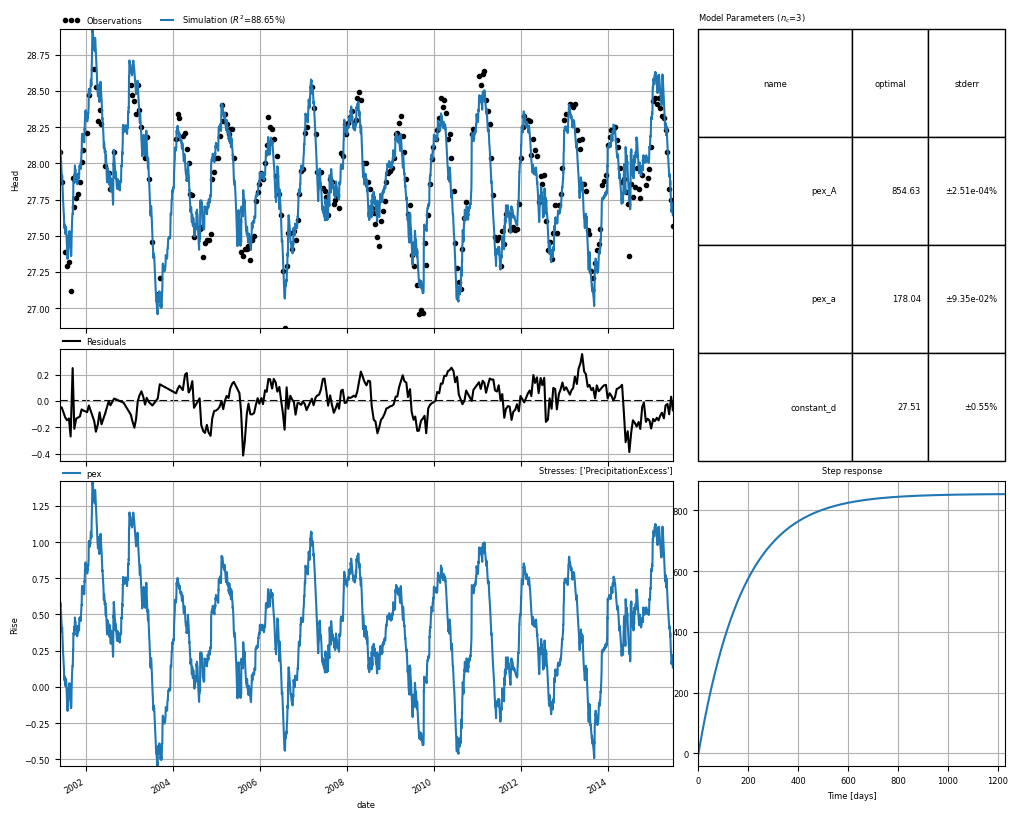

In [5]:
_ = ml.plots.results(stderr=True)

## Solve with Pest HP

In [6]:
ml_hp = ml.copy()
ml_hp.name = "PestHp"
solver = psp.PestHpSolver(
    exe_name="bin/pest_hp", exe_agent="bin/agent_hp", model_ws=Path("pestf_hp/model"), temp_ws=Path("pestf_hp/temp"), noptmax=30, port_number=4000,
)
ml_hp.solve(solver=solver, report=False)

2024-07-30 15:41:56.733367 starting: opening PstFrom.log for logging
2024-07-30 15:41:56.733940 starting PstFrom process
2024-07-30 15:41:56.734015 starting: setting up dirs
2024-07-30 15:41:56.734102 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp'
2024-07-30 15:41:56.736983 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp' took: 0:00:00.002881
2024-07-30 15:41:56.737103 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp'
2024-07-30 15:41:56.740139 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp' took: 0:00:00.003036
2024-07-30 15:41:56.742986 finished: setting up dirs took: 0:00:00.008971
2024-07-30 15:41:56.783064 transform was not passed, setting default tranform to 'log'
2024-07-30 15:41:56.7

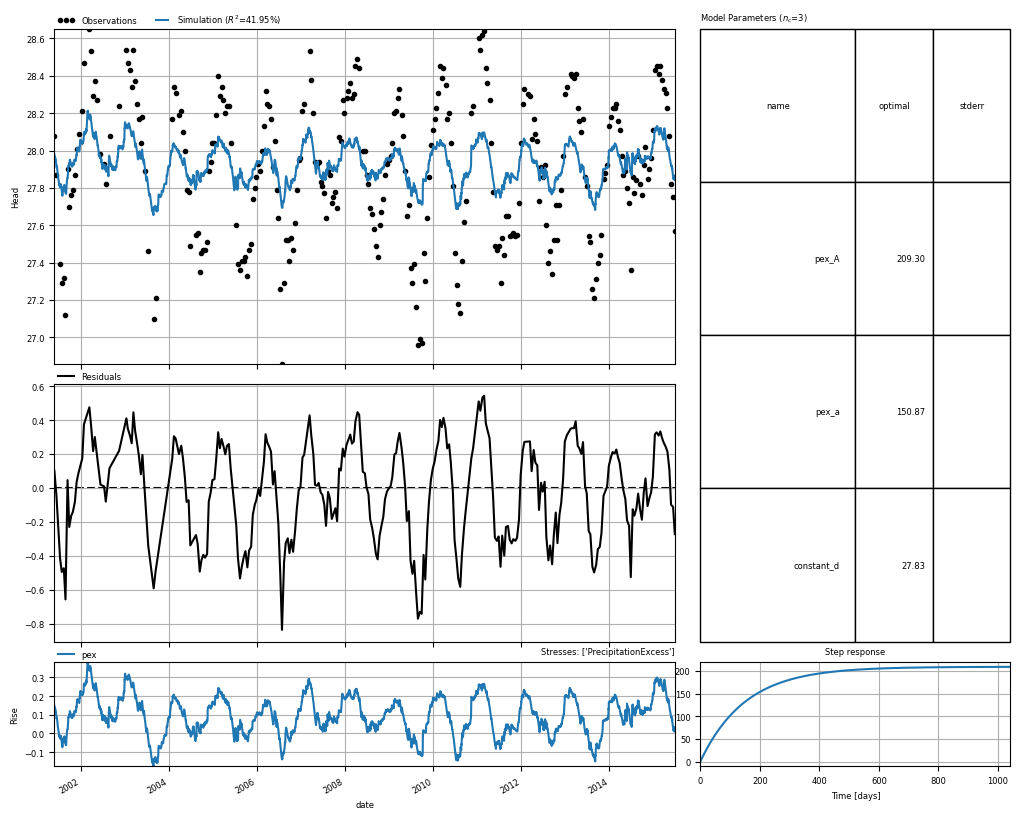

In [7]:
_ = ml_hp.plots.results(stderr=True)

In [8]:
ml_hp.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
pex_A,215.674528,0.00001,21402.071286,True,pex,uniform,NaN,209.301730
pex_a,10.000000,0.01000,1000.000000,True,pex,uniform,NaN,150.870270
constant_d,27.902000,17.90200,37.902000,True,constant,uniform,NaN,27.830993


## Solve with SciPy Least Squares

Fit report LeastSquares           Fit Statistics
nfev    26                     EVP         88.65
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1229.99
tmax    2015-06-28 00:00:00    BIC      -1218.96
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
               optimal     initial  vary
pex_A       850.895010  215.674528  True
pex_a       177.192164   10.000000  True
constant_d   27.508802   27.902000  True


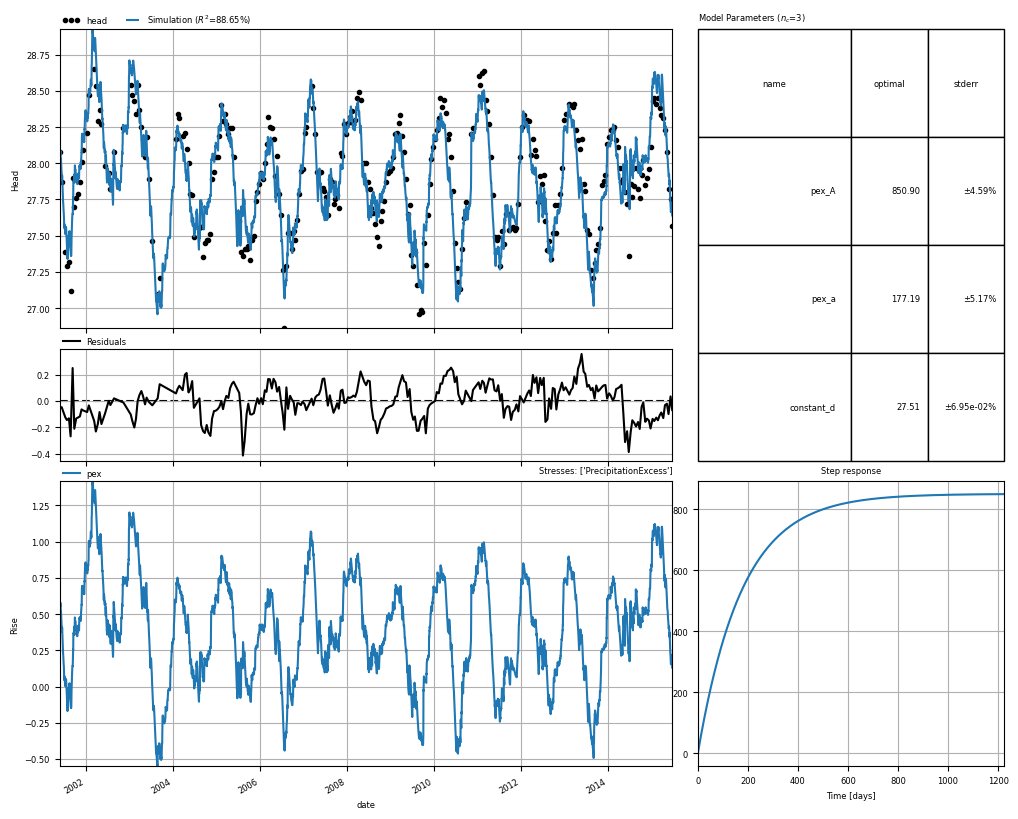

In [9]:
ml_ls = ml.copy()
ml_ls.name = "LeastSquares"
ml_ls.solve(solver=ps.LeastSquares())
_ = ml_ls.plots.results(stderr=True)

## Compare Results

### Plot

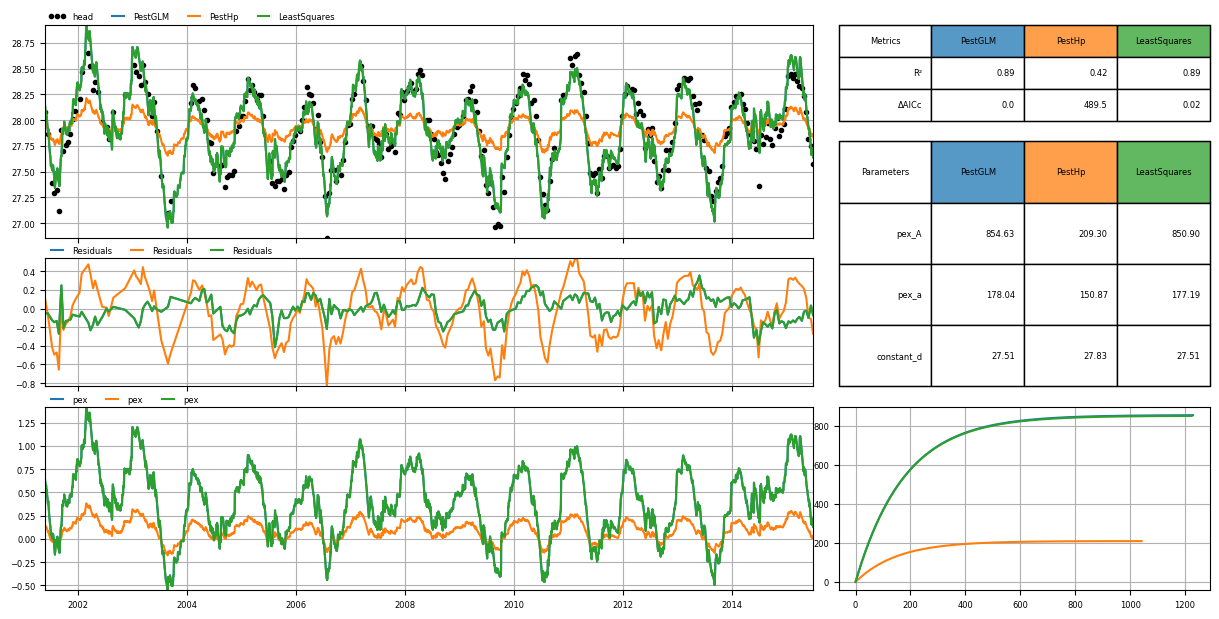

In [10]:
ps.plots.compare([ml, ml_hp, ml_ls], figsize=(12, 6));

### Fit metrics

In [11]:
pd.concat([ml.stats.summary(), ml_hp.stats.summary(), ml_ls.stats.summary()], axis=1, keys=[ml.name, ml_hp.name, ml_ls.name]).drop("rmsn")

,PestGLM,PestHp,LeastSquares
,Value,Value,Value
Statistic,,,
rmse,0.127436,0.288139,0.127439
sse,4.871948,24.907175,4.872242
mae,0.103352,0.240486,0.103322
nse,0.886460,0.419543,0.886453
evp,88.646019,42.424325,88.645334
rsq,0.886460,0.419543,0.886453
kge,0.917353,0.260028,0.916941
bic,-1218.975253,-729.476616,-1218.957152


### Parameters (and stderr)

In [12]:
pd.concat([ml.parameters.loc[:, ["optimal", "stderr"]], ml_hp.parameters.loc[:, ["optimal", "stderr"]], ml_ls.parameters.loc[:, ["optimal", "stderr"]]], axis=1, keys=[ml.name, ml_hp.name, ml_ls.name])

PestGLM                PestHp        LeastSquares           
             optimal    stderr     optimal stderr      optimal     stderr
pex_A       854.6310  0.002147  209.301730    NaN   850.895010  39.066252
pex_a       178.0440  0.166463  150.870270    NaN   177.192164   9.168716
constant_d   27.5071  0.150136   27.830993    NaN    27.508802   0.019113

### Covariance matrices

In [13]:
pd.concat([ml.solver.pcov, ml_ls.solver.pcov], axis=1, keys=[ml.name, ml_ls.name])

PestGLM                      LeastSquares                       
               pex_A     pex_a constant_d        pex_A       pex_a constant_d
pex_A       0.000005 -0.000278  -0.000291  1526.172038  319.406440  -0.688453
pex_a      -0.000278  0.027710   0.022031   319.406440   84.065354  -0.143179
constant_d -0.000291  0.022031   0.022541    -0.688453   -0.143179   0.000365

In [14]:
assert ml_hp.solver.pcov is None # PestHp does not provide the covariance matrix (by default)